<a href="https://colab.research.google.com/github/Skixio789/Bonus-Certificat/blob/main/StatisticalLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import torch
from torch import nn
import random
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import math
from tqdm import tqdm
from numpy.random import default_rng
rng = default_rng()
x0, K, r, T = 100, 105, 0.01, 1 # Constantes du problème
n = 100 # Constante pour la discrétisation de l'intervalle [0,1]

def brownian(): # Fonction générant un mouvement brownien standard
  brownien = np.zeros(n+1)
  brownien[1::] = np.sqrt(T/n)*rng.normal(size = n)
  brownien = np.cumsum(brownien)
  return brownien

def function_actif(sigma): # Fonction générant la trajectoire de l'actif sous-jacent
  actif = [x0]
  brownien = brownian()
  for i in range(1,n+1):
    actif.append(x0*np.exp((r-sigma**2/2)*i/(n)+sigma*brownien[i])) # Génération de l'actif sous jacent
  return actif

def payoff(sigma): # Calcul de C par la formule de Black-Scholes en fonction de la volatilité sigma
    actif = function_actif(sigma)
    d1 = (np.log(x0/K)+(r+sigma**2/2)*(T))/(sigma*np.sqrt(T)) # Constantes d1 et d2 dans la formule de Black-Scholes
    d2 = d1-sigma*np.sqrt(T)
    Nd1 = stats.norm.cdf(d1,0,1)
    Nd2 = stats.norm.cdf(d2,0,1)
    C = x0*Nd1-K*np.exp(-r*T)*Nd2 # Formule de Black-Scholes pour une option européenne
    return C

def data(m): # Génération de m valeurs de sigma dans l'intervalle [0.001,2] et de la valeur C(sigma) associée
  sigma = np.linspace(0.001,2,m)
  C = [payoff(sigma[k]) for k in range(m)]
  return sigma,C

def regression(m): # A partir de m données, on estime la valeur du prix du call C par C_hat = a_hat*sigma + b_hat --- Régression linéaire
  X = data(m)[0] # Données d'entraînement
  X = X.reshape(-1,1)
  y = data(m)[1]
  Reglin = LinearRegression() # Création du modèle
  Reglin.fit(X,y) # Entraînement
  a_hat,b_hat = Reglin.coef_[0], Reglin.intercept_ # Coefficients de la régression linéaire

  plt.plot(X,y,'r',label = '$C(\sigma)$') # Affichage du graphique
  plt.plot(X,a_hat*X+b_hat,'b',label='$\hat{C}(\sigma) (approximation)$')
  plt.title('Prix théorique et estimé du call européen, régression linéaire')
  plt.xlabel('$\sigma$')
  plt.ylabel('Prix du Call')
  plt.legend()
  plt.show()

  print("Le score du modèle de régression linéaire est ",Reglin.score(X, y)) # On souhaite avoir un score proche de 1
  Xtest = []
  Ytest = []
  for i in range(math.floor(0.2*m)): # On crée d'autres valeurs de sigma que l'on prédit avec ce modèle, et on calcule la MSE
    Xtest.append(random.uniform(0, 2))
    Ytest.append(payoff(Xtest[i])) # Génération de Ytest
  Xtest = np.reshape(Xtest, (-1, 1))
  predict = Reglin.predict(Xtest)
  print("Le MSE pour le modèle de régression linéaire est ",mean_squared_error(Ytest,predict))



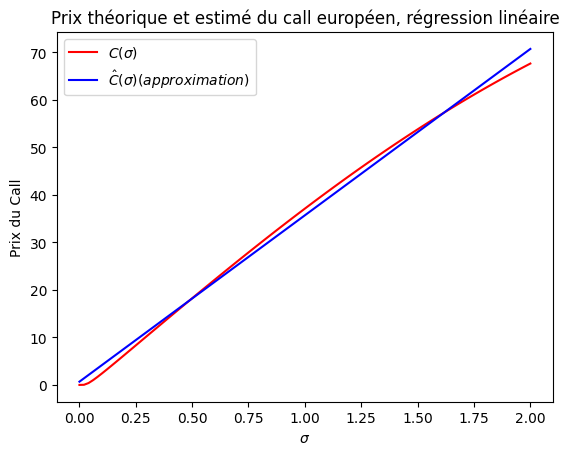

Le score du modèle de régression linéaire est  0.9963630281277291
Le MSE pour le modèle de régression linéaire est  1.6739671961659492


In [27]:
regression(100)

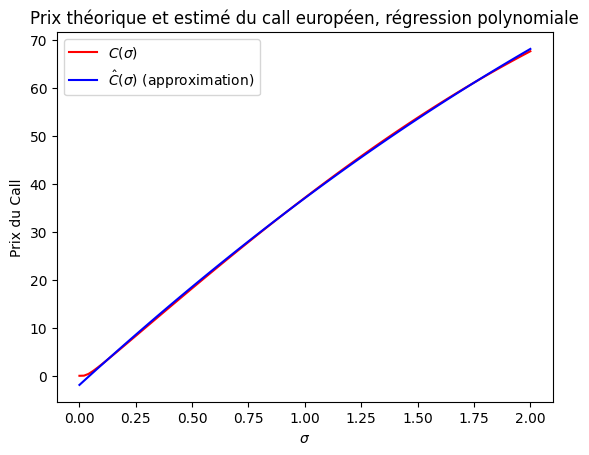

Le score du modèle de régression polynomiale est  0.9997678946819605
Le MSE pour le modèle de régression polynomiale est  0.1743112221956092


In [28]:
def regressionP(m,degree): # A partir de m données, on estime la valeur du prix du call C par C_hat = P(sigma) où P est un polynôme de degré "degree" --- Régression polynômiale
  X = data(m)[0] # Données d'entraînement (features)
  X = X.reshape(-1,1) # Détail technique
  y = data(m)[1] # Données d'entraînement (labels)

  plt.figure() # Affichage du graphique
  plt.plot(X,y,'r',label = '$C(\sigma)$')

  poly_features = PolynomialFeatures(degree=degree) # Création du modèle
  X_poly = poly_features.fit_transform(X)
  Reg = LinearRegression()
  Reg.fit(X_poly, y) # Entraînement du modèle

  plt.plot(X,Reg.predict(X_poly),'b',label = '$\hat{C}(\sigma)$ (approximation)') # Affichage du graphique
  plt.legend()
  plt.title('Prix théorique et estimé du call européen, régression polynomiale')
  plt.xlabel('$\sigma$')
  plt.ylabel('Prix du Call')
  plt.show()

  print("Le score du modèle de régression polynomiale est ",Reg.score(X_poly, y)) # On souhaite avoir un score proche de 1
  Xtest = []
  Ytest = []
  for i in range(math.floor(0.2*m)): # On crée d'autres valeurs de sigma que l'on prédit avec ce modèle, et on calcule la MSE
    Xtest.append(random.uniform(0, 2))
    Ytest.append(payoff(Xtest[i]))

  Xtest = np.reshape(Xtest, (-1, 1))
  Xtest_poly = poly_features.fit_transform(Xtest) # Transformation des données d'entraînement pour le modèle de régression polynômial
  predict = Reg.predict(Xtest_poly)
  print("Le MSE pour le modèle de régression polynomiale est ",mean_squared_error(Ytest,predict))
regressionP(100,2)

<ipython-input-26-dcf821cee2ce>:32: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(x0/K)+(r+sigma**2/2)*(T))/(sigma*np.sqrt(T)) # Constantes d1 et d2 dans la formule de Black-Scholes


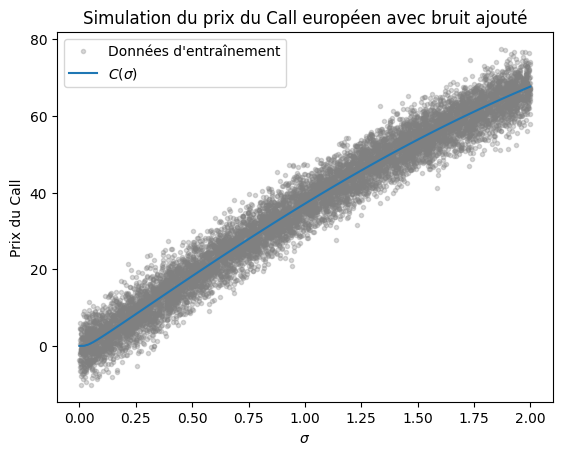

L'erreur quadratique moyenne avec les données d'entraînements sans bruits est 0.45764164792624307


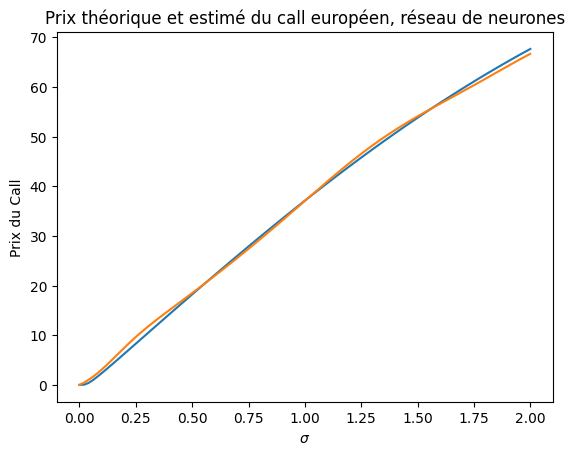

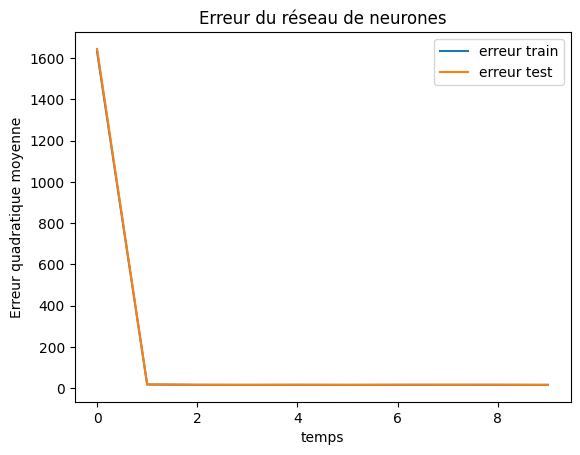

In [29]:
def neural_network():
  torch.random.manual_seed(10) # Seed de l'aléatoire
  random.seed(10) # Seed de l'aléatoire
  f = lambda x: payoff(x) # Définition de la fonction
  Ntrain = 10000 # Taille de l'ensemble d'entraînement
  Ntest = math.floor(Ntrain/5) # Taille de l'ensemble de test

  Xtrain = torch.rand((Ntrain,1))*2 # Génère un tenseur de taille N_train x 1 (matrice) rempli de random uniforme entre (0,1) , puis le tout multiplié par 2
  Xtest = torch.rand((math.floor(Ntrain/5),1))*2
  Xtest_sorted, indices = torch.sort(Xtest, dim=0) # Trie les données Xtest pour les afficher plus tard
  Xtest= Xtest_sorted

  Ytrain = torch.from_numpy(f(Xtrain.clone()))+torch.normal(mean = 0, std = 4,size = (Ntrain,1)) # On ajoute du bruit pour plus de réalisme sur l'entraînement du modèle
  Ytest = torch.from_numpy(f(Xtest.clone()))+torch.normal(mean = 0, std = 4,size = (Ntest,1)) # Idem

  Xtrain = Xtrain.float() # Détails techniques pour la suite du code
  Xtest = Xtest.float()
  Ytest = Ytest.float()
  Ytrain = Ytrain.float()

  plt.plot(Xtrain,Ytrain,".",color = "grey", alpha = 0.3,label = 'Données d\'entraînement') # Affichage du graphique
  plt.plot(np.linspace(0,2,100),f(np.linspace(0,2,100)),label = '$C(\sigma)$')
  plt.legend()
  plt.title('Simulation du prix du Call européen avec bruit ajouté')
  plt.xlabel('$\sigma$')
  plt.ylabel('Prix du Call')
  plt.show()

  my_network = nn.Sequential( # Création du réseau de neurones
            nn.Linear(1, 5),
            nn.Sigmoid(), # Fonction d'activation type Sigmoïde

            nn.Linear(5, 5),
            nn.Sigmoid(),

            nn.Linear(5, 1),
          )

  loss_function = nn.MSELoss(reduction='mean') # Fonction perte
  learning_rate = 1e-2 # Taux d'apprentissage
  error_train=[]
  error_test=[]
  batch_size=3000 # Taille du Batch
  num_steps=10000 # Nombre d'itération pour l'entraînement du modèle

  for t in range(num_steps):
    batch = np.random.choice(n, batch_size) # On choisit aléatoirement un mini-batch pour la SGD.
    X_batch, y_batch = Xtrain[batch], Ytrain[batch]

    # Forward
    Y_pred = my_network(X_batch)
    loss=loss_function(Y_pred,y_batch)
    my_network.zero_grad()

    # Backward
    loss.backward() # Autograd pour calculer les gradients
    with torch.no_grad():
        for param in my_network.parameters():
            param -= learning_rate * param.grad
    if t%math.floor(num_steps/10)==0: # On incrémente notre vecteur erreur_train et erreur_test de la MSE à intervalle de temps régulier durant l'entraînement du modèle
      error_train.append(loss_function(my_network(Xtrain),Ytrain).detach().numpy())
      error_test.append(loss_function(my_network(Xtest),Ytest).detach().numpy())

  plt.figure() # Affichage du graphique
  plt.plot(np.linspace(0,2,100),f(np.linspace(0,2,100)),label = '$C(\sigma)$')
  plt.plot(Xtest,my_network(Xtest)[:,0].detach().numpy(),label = '$\hat{C}(\sigma)$')
  plt.title('Prix théorique et estimé du call européen, réseau de neurones')
  plt.xlabel('$\sigma$')
  plt.ylabel('Prix du Call')

  plt.figure() # Affichage du graphique
  plt.plot(error_train, label='erreur train')
  plt.plot(error_test, label='erreur test')
  plt.title('Erreur du réseau de neurones')
  plt.xlabel('temps')
  plt.ylabel('Erreur quadratique moyenne')
  plt.legend()

  X = Xtest[:,0].detach().numpy() # Transformation de Xtest en tableau numpy pour calculer la MSE avec les données d'entraînement non bruitées
  Y = my_network(Xtest)[:,0].detach().numpy()
  a=0
  for i in range(np.shape(X)[0]): # Calcul de la MSE
    a+= (Y[i]-payoff(X[i]))**2
  print("L'erreur quadratique moyenne avec les données d'entraînements sans bruits est", a/np.shape(X)[0])
neural_network()